# Loading models and data and imports

In [1]:
from collections import OrderedDict
# from scipy import misc
# from imageio import imsave
import torch
import cv2
from data.cocostuff_loader import *
from data.vg import *
from model.resnet_generator_v2 import *
from utils.util import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from data.datasets import get_dataset, get_num_classes_and_objects
from torchvision.utils import draw_bounding_boxes, make_grid
from torchvision.transforms import Resize, ToPILImage, ToTensor
from PIL import ImageDraw
from typing import Union, Callable
from utils.depth import get_depth_layout
from numpy.random import randint


@dataclass
class MyArgs:
    dataset: str = ''
    model_path: str = ''
    model_depth_path: str = ''
    sample_path: str = ''


def load_model(path, net):
    if not os.path.isfile(args.model_path):
        print('Model not found')
        raise FileNotFoundError('Model not found')

    state_dict = torch.load(path)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`nvidia
        new_state_dict[name] = v

    model_dict = net.state_dict()
    pretrained_dict = {k: v for k,
                       v in new_state_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    net.load_state_dict(model_dict)

    net.cuda()
    net.eval()

    return net


args = MyArgs()
args.dataset = 'clevr-rubber'
args.model_depth_path = 'outputs/clevr-rubber-transf-feats3/G_200.pth'
args.model_path = 'outputs/clevr-rubber-baseline/G_200.pth'

num_classes, num_o = get_num_classes_and_objects(args.dataset)

dataset = get_dataset(args.dataset, 128, 'val',
                      num_obj=num_o,
                      return_filenames=True, return_depth=True)

idx2name = dataset.idx2label

netGdepth = ResnetGeneratorTransfFeats128(
    num_classes=num_classes, output_dim=3).cuda()
netGdepth = load_model(args.model_depth_path, netGdepth)

netGbase = ResnetGenerator128(
    num_classes=num_classes, output_dim=3).cuda()
netGbase = load_model(args.model_path, netGbase)

thres = 2.0


In [2]:
layout_index = 29


# Helper functions

In [3]:
def draw_bboxes(image: torch.Tensor, bbox: Union[torch.Tensor, np.ndarray], labels: torch.Tensor, text: bool = True, color_transform: list[int] = None, show_idx: bool = False) -> torch.Tensor:
    '''
    Draws bounding boxes on an image, optionally adds labels and objects' indices and colors some specified bounding boxes

    Args:
        image: image
        bbox: bounding boxes coordinates in the format (x, y, w, h)
        labels: labels
        text: True to visualize text labels in each bbox
        show_idx: if True each bbox index (row of the bbox tensor) will be visualized
        color_transform: list of bbox indices representing the bboxes to be colored in red

    Returns:
        image: the image after drawing the bboxes on it
    '''

    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    colors = None
    label_str = None

    # scale boxes to image size
    # boxes with xmax and ymax
    coord_boxes = scale_boxes(
        bbox, image.shape[-2:], 'coordinates', dtype=torch.int)

    if color_transform is not None:
        # all non-transformed bboxes will be white
        colors = [(255, 255, 255) for _ in range(len(labels))]

        # color transformed bboxes in red
        for i in color_transform:
            colors[i] = (255, 0, 0)

    # show object row index in the tensor
    if show_idx:
        label_str = [str(i) for i in range(len(labels))]

    # show textual label
    if text:
        if show_idx:
            # show both text and objects' indices
            label_str = [label_str[i]+'-'+idx2name[labels[i]]
                         for i in range(len(labels))]
        else:
            label_str = [idx2name[l] for l in labels]

    # draw bboxes
    image = draw_bounding_boxes(
        image, coord_boxes, labels=label_str, colors=colors)

    return image


In [4]:
def sample_one(idx: int = None, show_labels: bool = False):
    '''
    Selects a random layout and displays the real image, the fake images generated by both the baseline model and the depth-aware model

    Args:
        idx: image position in the dataset. If none is specified a random one will be selected
        show_labels: if True the labels will be visualized on the layout
    '''

    # if no image is specified, select a random one
    idx = int(np.ceil(np.random.random()*len(dataset)) -
              1) if idx is None else idx
    print(f'Image: {idx}')

    # control plot order and size
    cols, ax_id, figH = (3, 0, 4)
    figsize = (figH*cols, figH)

    _, axs = plt.subplots(1, cols, figsize=figsize)

    real, labels, bbox, depth = dataset[idx]

    # print each object depth value
    print([(i, d.item()) for i, d in enumerate(depth)])

    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    # scale bounding boxes for visualization
    coord_box = scale_boxes(
        bbox, dataset.image_size, 'coordinates', dtype=torch.int)

    # display layout by
    # displaying bounding boxes on a black tensor
    layout = torch.zeros(3, 128, 128).type(torch.uint8)
    layout = draw_bboxes(layout, bbox, labels, show_idx=True, text=False)

    axs[ax_id].imshow(layout.permute(1, 2, 0))
    axs[ax_id].set_title('Layout with indices')
    ax_id += 1

    # get depth layout
    depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)

    axs[ax_id].imshow(depth_layout, cmap='gray')
    axs[ax_id].set_title('Depth layout')
    ax_id += 1

    # normalize from [-1,1] to [0,255]
    real = ((real.cpu() + 1) / 2 * 255).type(torch.uint8)

    # draw boxes
    real = draw_bounding_boxes(real, coord_box)

    axs[ax_id].imshow(real.permute(1, 2, 0))
    axs[ax_id].set_title('Real image with bounding boxes')

    # display fake images
    _, axs = plt.subplots(1, 2, figsize=(figH*2, figH))
    fake_images = []

    # sample noise vectors
    z_obj = torch.from_numpy(truncted_random(
        num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(
        num_o=1, thres=thres)).view(1, -1).float().cuda()

    # sample baseline
    fake = netGbase.forward(
        z_obj, bbox.clone().cuda().unsqueeze(0), z_im, labels.clone().long().cuda())

    # normalize from [-1,1] to [0,1]
    fake_images.append(fake.detach().squeeze().permute(
        1, 2, 0).cpu() * 0.5 + 0.5)

    # sample depth-aware
    fake = netGdepth.forward(z_obj, bbox.clone().cuda().unsqueeze(
        0), z_im=z_im, y=labels.clone().long().cuda(), depths=depth.cuda().unsqueeze(0))

    # normalize from [-1,1] to [0,1]
    fake_images.append(fake.detach().squeeze().permute(
        1, 2, 0).cpu() * 0.5 + 0.5)

    axs[0].imshow(fake_images[0])
    axs[0].set_title('Baseline fake image')
    axs[1].imshow(fake_images[1])
    axs[1].set_title('Depth-aware fake image')


# Direct comparison
Feed the same layout and noise to both models and compare the result

In [5]:
def direct_comparison(num_gen: int = 6):
    '''
    Sample `num_gen` layout randomly from the dataset, the generate baseline fakes and depth-aware fakes for each one and display the result in a grid.
    '''

    # add text with PIL
    to_pil = ToPILImage()
    to_tens = ToTensor()

    fakes = []

    for idx in randint(0, len(dataset), num_gen):
        real, label, bbox, depth = dataset[idx]

        if isinstance(bbox, np.ndarray):
            bbox = torch.from_numpy(bbox)


        # get depth layout
        depth_layout = get_depth_layout(depth, real.shape[-2:], bbox).unsqueeze(0)

        coord_box = scale_boxes(
            bbox, dataset.image_size, 'coordinates', dtype=torch.int)

        # sample noise vectors
        z_obj = torch.from_numpy(truncted_random(
            num_o=num_o, thres=thres)).float().cuda()
        z_im = torch.from_numpy(truncted_random(
            num_o=1, thres=thres)).view(1, -1).float().cuda()

        # baseline fake
        fake_images_base = netGbase.forward(z_obj, bbox.clone().cuda().unsqueeze(
            0), z_im, label.long().cuda()).squeeze()

        # depth-aware fake
        fake_images = netGdepth.forward(z_obj, bbox.clone().cuda().unsqueeze(
            0), z_im=z_im, y=label.long().cuda(), depths=depth.clone().cuda().unsqueeze(0)).squeeze()

        # normalize from [-1,1] to [0,255] and convert to PIL image
        fake_images_base, fake_images = to_pil(((fake_images_base.detach() + 1) / 2 * 255).type(
            torch.uint8).cpu()), to_pil(((fake_images.detach() + 1) / 2 * 255).type(torch.uint8).cpu())

        base_draw, depth_draw = ImageDraw.Draw(
            fake_images_base), ImageDraw.Draw(fake_images)

        base_draw.text((0, 0), 'baseline', (0, 0, 0))
        depth_draw.text((0, 0), 'depth-aware', (0, 0, 0))

        # stack tensors: depth-layout, baseline fake, depth-aware fake
        # tensors are now in [0,1]
        fakes.append(torch.cat((
            torch.cat((depth_layout, depth_layout, depth_layout), 0), to_tens(fake_images_base), to_tens(fake_images)
            ), dim=1))
    
    # build a grid and plot
    fig = plt.figure(figsize=(15, 5*num_gen))
    plt.imshow(make_grid(fakes, nrow=num_gen).permute(1,2,0))
    plt.axis('off')


/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


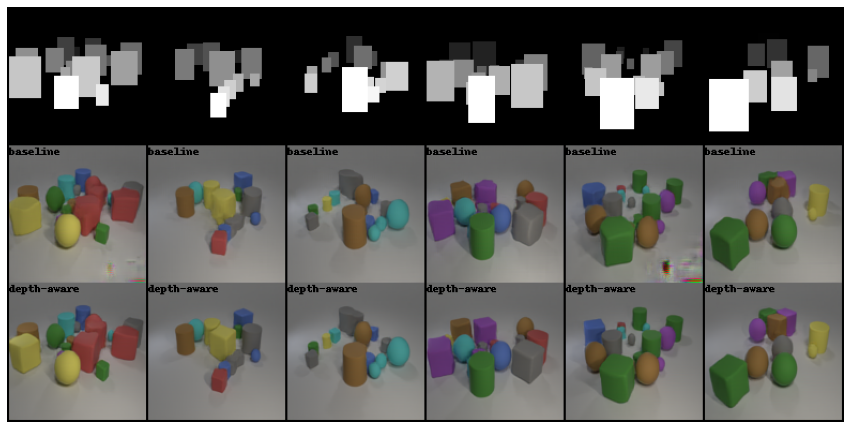

In [6]:
direct_comparison()

# Diversity
We generate multiple images from the same layout to see the model is capable of generating diverse images given the same input

The model has three inputs: layout (bounding boxes and labels), a noise vector determining each object's appearance and another noise vector determining the overall image appearance.

We define a function that allows to fix some of these inputs and generating multiple images letting the others vary.

In [7]:
def variable_inputs(variable: list[str], netG: nn.Module, num_gen: int = 23, max_cols: int = 6, figsize: tuple[int] = (18, 12), layout_idx: int = 0, transform_bbox: list[int] = None, transform: Callable = None, show_idx: bool = False, show_labels: bool = False, use_depth: bool = False):
    '''
    Generates multiple images with provided model, while keeping all inputs fixed except the ones specified in the `variable` parameter

    Args:
        variable: list of inputs that will vary at each generation. Can be `layout`, `z_obj`, `z_img` or a combination of them
        netG: generative model
        num_gen: number of images to be generated
        max_cols: max numer of columns used to display the result
        figsize: figure size
        layout_idx: layout index in the dataset
        transform_bbox: list of indices indicating the bboxes to be transformed
        transform: function used to transform the bboxes indicated by `transform_bbox`
        show_idx: if True each bbox index (row of the bbox tensor) will be visualized
        show_labels: labels will be visualized on the layout if set to True
        use_depth: if True depth information will be used as input to the model
    '''

    fakes = []

    # fixed inputs

    if not 'layout' in variable:
        # the layout is a fixed input, take it from the dataset once outside of the loop

        _, label, bbox, depth = dataset[layout_idx]

        if isinstance(bbox, np.ndarray):
            bbox = torch.from_numpy(bbox)

        # display layout by displaying bounding boxes on a black tensor
        layout = torch.zeros(3, 128, 128).type(torch.uint8)

        # if a bbox gets transformed, color it in red on the layout
        if transform_bbox is not None:
            # color transformed bboxes in red
            layout = draw_bboxes(
                layout, bbox, label, color_transform=transform_bbox, show_idx=show_idx, text=show_labels)
        else:
            layout = draw_bboxes(layout, bbox, label,
                                 show_idx=show_idx, text=show_labels)

        fakes.append(layout.permute(1, 2, 0))

    # fixed noise vectors, sample them once outside of the loop
    if not 'z_obj' in variable:
        z_obj = torch.from_numpy(truncted_random(
            num_o=num_o, thres=thres)).float().cuda()
    if not 'z_img' in variable:
        z_im = torch.from_numpy(truncted_random(
            num_o=1, thres=thres)).view(1, -1).float().cuda()

    # varying inputs
    # use different once for each generated image
    for idx in range(num_gen):

        # if the layout is variable get a new one at each iteration
        if 'layout' in variable:
            _, label, bbox, depth, *_ = dataset[layout_idx+idx]

            if isinstance(bbox, np.ndarray):
                bbox = torch.from_numpy(bbox)

            # display layout by displaying bounding boxes on a black tensor
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox, label, show_idx=show_idx)
            fakes.append(layout.permute(1, 2, 0))

        bbox_cp = bbox.clone()

        # transform some bounding boxes if required
        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                # if not transformation is provided, apply a random one
                if transform is None:
                    bbox_cp[box_i] = torch.tensor(
                        [xl+random.uniform(-0.5, 0.5), yl+random.uniform(-0.5, 0.5), w*random.uniform(0, 2), h*random.uniform(0, 2)])
                else:
                    bbox_cp = transform(box_i, idx, bbox_cp)

            # display layout by displaying bounding boxes on a black tensor
            # coloring the transformed ones in red
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(
                layout, bbox_cp, label, color_transform=transform_bbox, show_idx=show_idx)
            fakes.append(layout.permute(1, 2, 0))

        # sample new noise vectors at each iteration
        if 'z_obj' in variable:
            z_obj = torch.from_numpy(truncted_random(
                num_o=num_o, thres=thres)).float().cuda()
        if 'z_img' in variable:
            z_im = torch.from_numpy(truncted_random(
                num_o=1, thres=thres)).view(1, -1).float().cuda()

        if use_depth:
            fake_images = netG.forward(z_obj, bbox_cp.cuda().unsqueeze(
                0), z_im=z_im, y=label.long().cuda(), depths=depth.cuda().unsqueeze(0))
        else:
            fake_images = netG.forward(
                z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        # normalize from [-1,1] to [0,1]
        fakes.append(fake_images.detach().squeeze().permute(
            1, 2, 0).cpu() * 0.5 + 0.5)

    # put all images in a plot grid
    n_rows = int(math.ceil((len(fakes))/6))
    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in enumerate(fakes):
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)


Generate multiple images form the same layout using the both the baseline and the depth-aware models

Baseline model


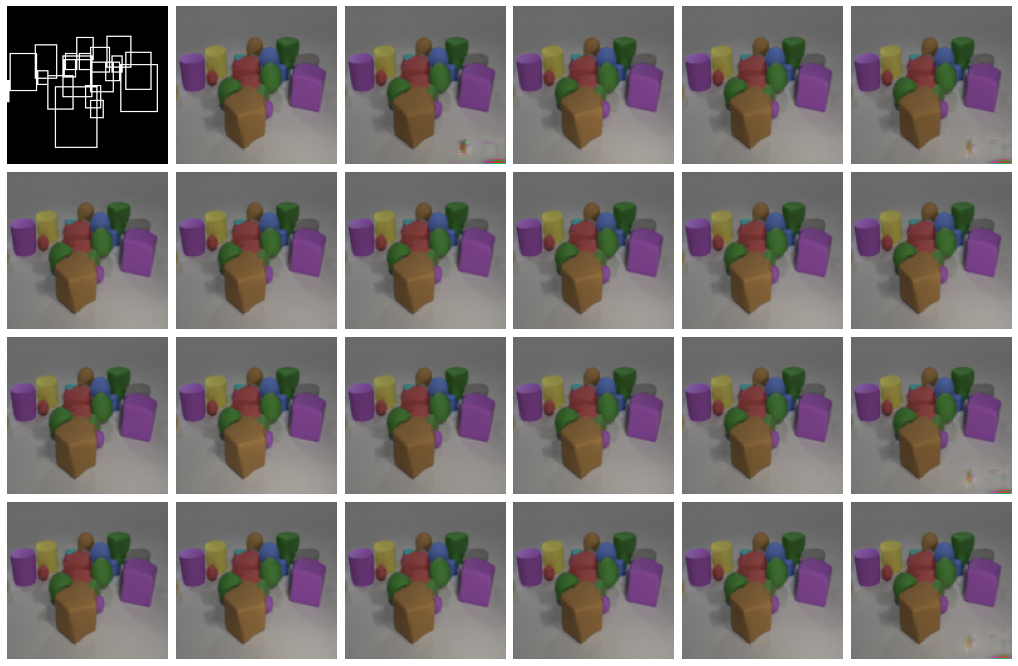

In [8]:
print('Baseline model')
variable_inputs(['z_obj', 'z_img'], netGbase, layout_idx=layout_index)


Depth-aware model


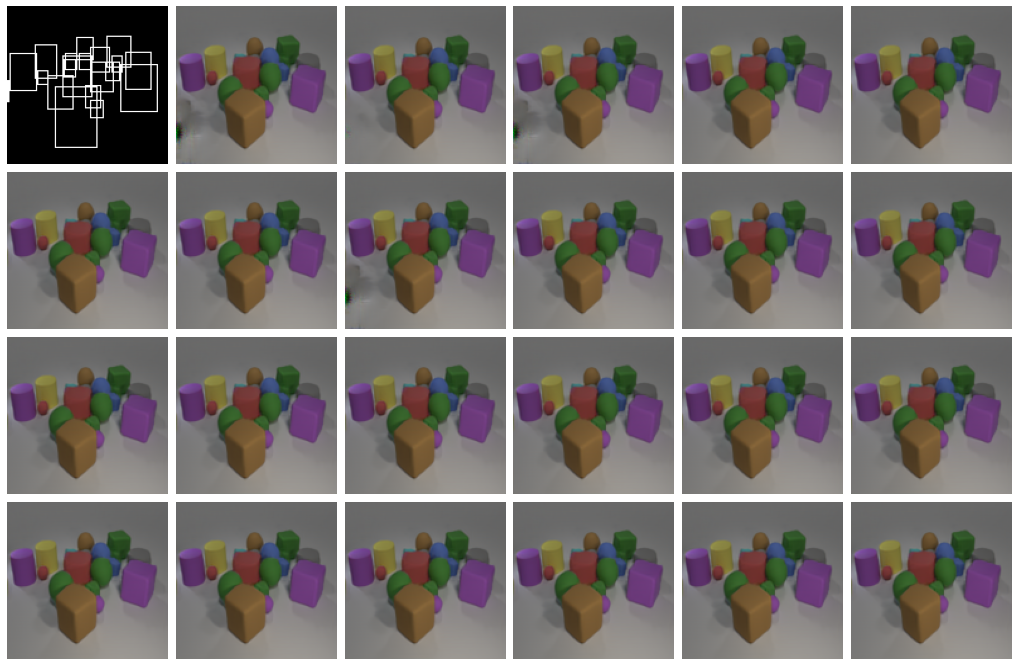

In [9]:
print('Depth-aware model')
variable_inputs(['z_obj', 'z_img'], netGdepth,
                layout_idx=layout_index, use_depth=True)


# Depth swap
Given a layout, we swap the depth values of two objects that form an occlusion, the ideal result would be that their ordering also gets invertend in the generated image.

For example, if object A in behind object B and we swap their depth values, object B should now be behind object A.

In [10]:
def depth_transform(idx: int, frames: int = 2, transform_idx: list[int] = None, transform: Callable = None, transform_args=None):
    '''
    Displays the layout, original image, fake image generated by the baseline model, depthmap and the fake image generated by the depth-aware model.
    Then a transformation (can modify depth information) is applied to the bboxes in `transform_idx` and the depth-aware fake is generated again and displayed.

    Args:
        idx: layout index in the dataset
        frames: number of image generated by the layout
        transform_idx: indices of the bboxes to be transformed
        transform: function used to transform bboxes
        transform_args: additional arguments to be passed to the transform function
    '''

    # control plot order and size
    rows, cols, figsize = frames, 2, (12, 4)
    figsized = (9, 9)

    _, axs = plt.subplots(1, 3, figsize=figsize)
    _, axsd = plt.subplots(rows, cols, figsize=figsized)

    real, label, bbox, depth = dataset[idx]

    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    #### DISPLAY ORIGINAL ###

    # get depth layout
    depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)

    axs[0].imshow(depth_layout, cmap='gray')
    axs[0].set_title('Original depth layout')

    coord_box = scale_boxes(
        bbox, dataset.image_size, 'coordinates', dtype=torch.int)

    # from [-1,1] to [0,255]
    real = ((real.cpu() + 1) / 2 * 255).type(torch.uint8)
    # draw boxes
    real = draw_bounding_boxes(real, coord_box)

    axs[1].imshow(real.permute(1, 2, 0))
    axs[1].set_title('Real image')

    # sample new noise vectors at each iteration
    z_obj = torch.from_numpy(truncted_random(
        num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(
        num_o=1, thres=thres)).view(1, -1).float().cuda()

    # generate fake
    fake = netGbase.forward(z_obj, bbox.clone().cuda().unsqueeze(
        0), z_im, label.long().cuda()).squeeze()
    axs[2].imshow(fake.detach().permute(1, 2, 0).cpu()*0.5+0.5)
    axs[2].set_title('Baseline fake image')

    #### TRANSFORM AND GENERATE ####

    for t in range(frames):
        if transform_idx is not None and transform is not None:
            for box_i in transform_idx:
                if transform_args is None:
                    bbox, depth = transform(box_i, t, bbox, depth)
                else:
                    bbox, depth = transform(
                        box_i, t, bbox, depth, *transform_args)

        # t = 0 -> unmodified fake

        # new depth layout
        depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)
        axsd[t, 0].imshow(depth_layout, cmap='gray')
        if t == 0:
            axsd[t, 0].set_title(f'Original depth layout')
        else:
            axsd[t, 0].set_title(f'Modified depth layout {t}')

        # new fake
        fake = netGdepth.forward(z_obj, bbox.clone().cuda().unsqueeze(
            0), z_im=z_im, y=label.long().cuda(), depths=depth.clone().cuda().unsqueeze(0)).squeeze()
        axsd[t, 1].imshow(fake.detach().permute(1, 2, 0).cpu()*0.5+0.5)
        axsd[t, 1].set_title(f'Depth-aware fake {t+1}')

        print(f'Fake {t+1} depths: {[(i, d) for i, d in enumerate(depth)]}')


Fake 1 depths: [(0, tensor(0.7054)), (1, tensor(0.9613)), (2, tensor(0.8555)), (3, tensor(1.)), (4, tensor(0.3789)), (5, tensor(0.1254)), (6, tensor(0.6736)), (7, tensor(0.7906)), (8, tensor(0.8736)), (9, tensor(0.7218)), (10, tensor(0.1825)), (11, tensor(0.)), (12, tensor(0.4401)), (13, tensor(0.5999)), (14, tensor(0.5211)), (15, tensor(0.3638)), (16, tensor(0.0589)), (17, tensor(0.1556)), (18, tensor(-0.5000)), (19, tensor(-0.5000))]
Fake 2 depths: [(0, tensor(0.7054)), (1, tensor(0.9613)), (2, tensor(0.8555)), (3, tensor(1.)), (4, tensor(0.1254)), (5, tensor(0.3789)), (6, tensor(0.6736)), (7, tensor(0.7906)), (8, tensor(0.8736)), (9, tensor(0.7218)), (10, tensor(0.1825)), (11, tensor(0.)), (12, tensor(0.4401)), (13, tensor(0.5999)), (14, tensor(0.5211)), (15, tensor(0.3638)), (16, tensor(0.0589)), (17, tensor(0.1556)), (18, tensor(-0.5000)), (19, tensor(-0.5000))]


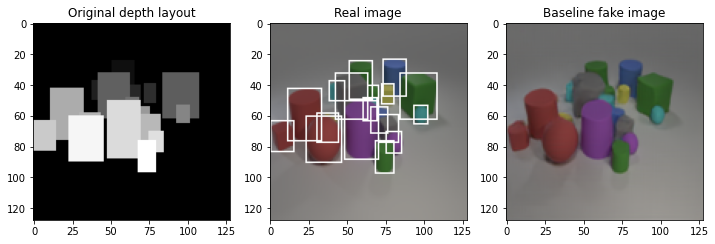

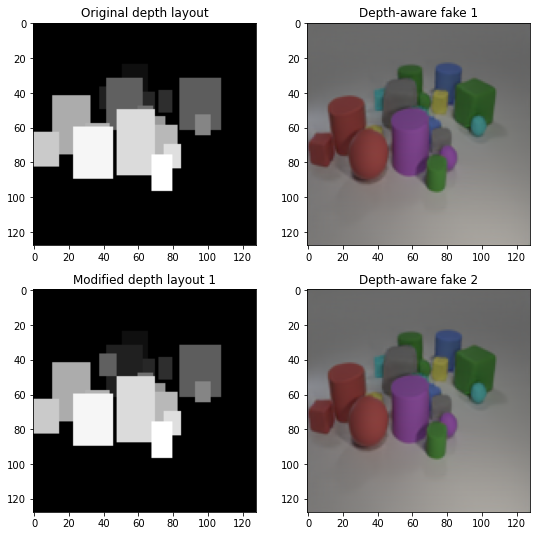

In [11]:
def swap_depth_transform(box_i, t, bbox, depth, a, b):
    if t > 0:
        tmp = depth[a].clone()
        depth[a] = depth[b].clone()
        depth[b] = tmp

    return bbox, depth


# depth_transform(830, transform_idx=[0], transform=swap_depth_transform, transform_args=(4,5))
depth_transform(154, transform_idx=[
    0], transform=swap_depth_transform, transform_args=(4, 5))
# depth_transform(416, transform_idx=[0], transform=swap_depth_transform, transform_args=(3,2))
# depth_transform(216, transform_idx=[0], transform=swap_depth_transform, transform_args=(3,2))


# Varying occlusions
We select an object partecipating in an occlusion and move it around so that its occluded area (or the occluded area of the object behind it) increases or decreases.

The object can also leave one occlusion and start occluding/being occluded by another object.

We generate multiple images by moving the object by N pixels each time and collect the images in a video for easier visualization.

In [12]:
def move_objects_video(num_gen: int = 23, max_cols: int = 6, figsize: tuple[int] = (20, 13), layout_idx: int = 0, transform_bbox: list[int] = None, transform: Callable = None, pixels: int = 1, vid_name: str = None, max_plot: int = None):
    '''
    Given one layout, multiple frames are generated using both the baseline and the depth-aware model.
    In each frame some bounding boxes are moved/transformed.
    Generated frames are stacked on each other (baseline on top, depth-aware on bottom) and saved in a video for easier comparison.

    Args:
        num_gen: number of frames generated
        max_cols: max numer of columns used to display the result
        figsize: figure size
        layout_idx: layout index in the dataset
        transform_bbox: list of indices indicating the bboxes to be transformed
        transform: function used to transform the bboxes indicated by `transform_bbox`
        pixels: displacement in pixels of the transformed objects at each frame
        vid_name: the video filename will be {dataset name}_{`vid_name`}_{`layout_idx`}.avi
    '''

    fakes = []

    z_obj = torch.from_numpy(truncted_random(
        num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(
        num_o=1, thres=thres)).view(1, -1).float().cuda()

    for idx in range(num_gen):

        if idx == 0:
            _, label, bbox, depth, *_ = dataset[layout_idx]

            if isinstance(bbox, np.ndarray):
                bbox = torch.from_numpy(bbox)

            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(
                layout, bbox, label, text=False, show_idx=True, color_transform=transform_bbox)
            fakes.append(layout.permute(1, 2, 0))
            bbox_cp = bbox.clone()

        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                if transform is None:
                    # slightly move to the right
                    bbox_cp[box_i] = torch.tensor(
                        [xl+pixels*(1/128), yl, w, h])
                else:
                    bbox_cp = transform(box_i, idx, pixels, bbox_cp)

        fake_images = netGdepth.forward(z_obj, bbox_cp.cuda().unsqueeze(
            0), z_im=z_im, y=label.long().cuda(), depths=depth.cuda().unsqueeze(0))

        fake_images_base = netGbase.forward(
            z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        # add text with PIL
        to_pil = ToPILImage()
        to_tens = ToTensor()

        # normalize from [-1,1] to [0,255] and convert to PIL image
        fake_images_base, fake_images = to_pil(((fake_images_base.detach().squeeze().cpu() + 1) / 2 * 255).type(
            torch.uint8)), to_pil(((fake_images.detach().squeeze().cpu() + 1) / 2 * 255).type(torch.uint8))

        base_draw, depth_draw = ImageDraw.Draw(
            fake_images_base), ImageDraw.Draw(fake_images)

        base_draw.text((0, 0), 'baseline', (0, 0, 0))
        depth_draw.text((0, 0), 'depth-aware', (0, 0, 0))

        # normal on top, depth on bottom
        # tensors are now in [0,1]
        fake_images = torch.cat(
            (to_tens(fake_images_base), to_tens(fake_images)), dim=1).permute(1, 2, 0)

        # back to [0,255] uint8
        fakes.append(
            (fake_images*255).type(torch.uint8).numpy().astype(np.uint8))

    if not Path('samples/vids/').is_dir():
        os.makedirs('samples/vids/')

    h, w, c = fakes[1].shape
    filename = f'samples/vids/{args.dataset}_{vid_name}_{layout_idx}.avi'

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    writer = cv2.VideoWriter(filename, fourcc, 10, (w, h))

    # save frames as a video
    for frame in fakes[1:]:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        writer.write(frame)

    writer.release()

    # plot max_plot frames in a grid
    if max_plot is None:
        end_for = enumerate(fakes)
        n_rows = int(math.ceil((len(fakes))/6))
    else:
        end_for = enumerate(fakes[:max_plot])
        n_rows = int(math.ceil(max_plot / 6))

    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in end_for:
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)

In [13]:
def move_down(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl+pixels*(1/128), w, h])
    return bbox


def move_up(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl-pixels*(1/128), w, h])
    return bbox


def move_left(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl-pixels*(1/128), yl, w, h])
    return bbox


def move_right(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl+pixels*(1/128), yl, w, h])
    return bbox


def move_left_bigger(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    dh = 60/128 if idx == 0 else 0
    bbox[box_i] = torch.tensor([xl-pixels*(1/128), yl, w, h+dh])
    return bbox


def right_diag(box_i, idx, pixels, bbox):
    bbox = move_up(box_i, idx, pixels, bbox)
    bbox = move_right(box_i, idx, pixels, bbox)
    return bbox

# move_objects_video(figsize=(18, 6), num_gen=120, layout_idx=29, transform_bbox=[4], transform=move_right, vid_name='1', max_plot=6)
